In [1]:
import pymc as pm
import numpy as np
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt

np.set_printoptions(edgeitems=3,infstr='inf',
linewidth=75, nanstr='nan', precision=8,
suppress=False, threshold=1000, formatter=None)

figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=False)
challenger_data = np.genfromtxt("data/kickstarter_data.csv", skip_header=1,
                                 missing_values=".",
                                delimiter=",")
#print challenger_data[:, 1]
# drop the NA values
#challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

# plot it, as a function of temperature (the first column)
#print "Temp (F), O-Ring failure?"
print challenger_data

"""id	d_state	priorsuccess	later_projects	d_later_projects	creator_id	l_goal	l_pledged	social_skill	l_quality	coleman_liau	l_video	l_image	l_days_between_project	l_duration	log_later_projects	launched_at	d_cat1	d_cat2	d_cat3	d_cat4	d_cat5	d_cat6	d_cat7	d_cat8	d_cat9	d_cat10	d_cat11	d_cat12	d_cat13	d_cat14	d_cat15	d_year1	d_year2	d_year3	d_year4	d_year5	d_year6
"""

[[  5.587e+08   1.000e+00   0.000e+00 ...,   0.000e+00   0.000e+00
    0.000e+00]
 [  1.861e+09   0.000e+00   0.000e+00 ...,   0.000e+00   0.000e+00
    0.000e+00]
 [  1.658e+09   1.000e+00   0.000e+00 ...,   0.000e+00   0.000e+00
    0.000e+00]
 ..., 
 [  1.769e+09   1.000e+00   0.000e+00 ...,   0.000e+00   0.000e+00
    0.000e+00]
 [  8.923e+08   0.000e+00   0.000e+00 ...,   0.000e+00   1.000e+00
    0.000e+00]
 [  1.316e+09   1.000e+00   0.000e+00 ...,   0.000e+00   0.000e+00
    1.000e+00]]


'id\td_state\tpriorsuccess\tlater_projects\td_later_projects\tcreator_id\tl_goal\tl_pledged\tsocial_skill\tl_quality\tcoleman_liau\tl_video\tl_image\tl_days_between_project\tl_duration\tlog_later_projects\tlaunched_at\td_cat1\td_cat2\td_cat3\td_cat4\td_cat5\td_cat6\td_cat7\td_cat8\td_cat9\td_cat10\td_cat11\td_cat12\td_cat13\td_cat14\td_cat15\td_year1\td_year2\td_year3\td_year4\td_year5\td_year6\n'

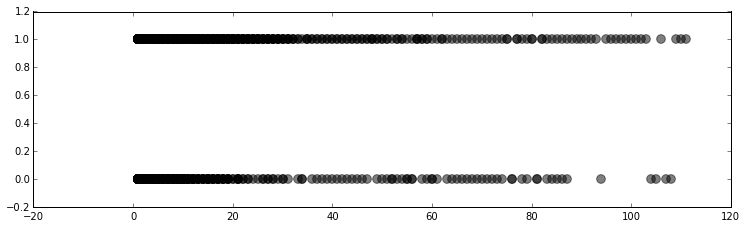

In [2]:
#plt.scatter(challenger_data[:, 1], challenger_data[:, 2], s=75, color="k",alpha=0.5)

#plt.yticks([0, 1])
#plt.ylabel("Success")
#plt.xlabel("Pass success")
#plt.title("Success vs pass success")


plt.scatter(challenger_data[:, 3], challenger_data[:, 1] , s=75, color="k",
            alpha=0.5)



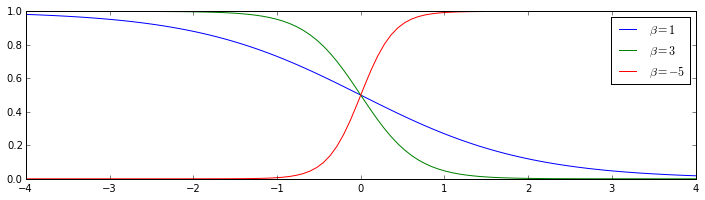

In [3]:
figsize(12, 3)


def logistic(x, beta):
    return 1.0 / (1.0 + np.exp(beta * x))

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r"$\beta = 1$")
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$")
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$")
plt.legend();

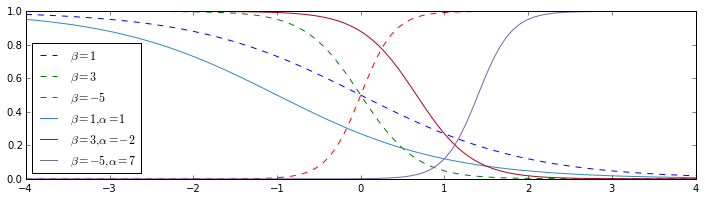

In [4]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)

plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")

plt.legend(loc="lower left");

[(-2, 0.7, '#348ABD'), (0, 1, '#A60628'), (3, 2.8, '#7A68A6')]


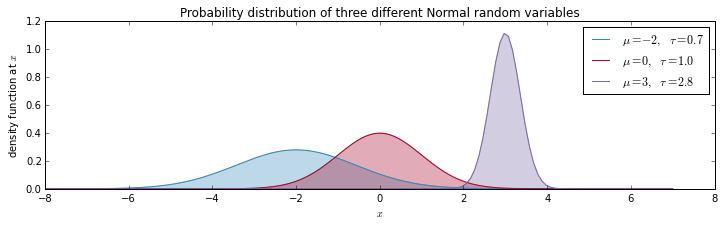

In [5]:
import scipy.stats as stats

nor = stats.norm
x = np.linspace(-8, 7, 150)
mu = (-2, 0, 3)
tau = (.7, 1, 2.8)
colors = ["#348ABD", "#A60628", "#7A68A6"]
parameters = zip(mu, tau, colors)
print parameters

for _mu, _tau, _color in parameters:
    plt.plot(x, nor.pdf(x, _mu, scale=1. / _tau),
             label="$\mu = %d,\;\\tau = %.1f$" % (_mu, _tau), color=_color)
    plt.fill_between(x, nor.pdf(x, _mu, scale=1. / _tau), color=_color,
                     alpha=.33)

plt.legend(loc="upper right")
plt.xlabel("$x$")
plt.ylabel("density function at $x$")
plt.title("Probability distribution of three different Normal random \
variables");

In [6]:
print challenger_data[:,2:4]
print challenger_data[:, 3]

[[ 0.  1.]
 [ 0.  1.]
 [ 0.  2.]
 ..., 
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]
[ 1.  1.  2. ...,  1.  1.  1.]


In [7]:
#d_state	priorsuccess	later_projects
project_id = challenger_data[:, 0]
d_state = challenger_data[:, 1]  # defect or not?
priorsuccess = challenger_data[:, 2]  # defect or not?
later_projects = challenger_data[:, 3]  # defect or not?


# notice the`value` here. We explain why below.
#beta = pm.Normal("beta", 0, 0.001, value=0)

N = 2

beta = np.empty(N, dtype=object)
for i in range(0, N):
    beta[i] = pm.Normal('x_%i' % i, 0, 0.001, value=0)

                       
alpha = pm.Normal("alpha", 0, 0.001, value=0)

print beta[0].value
print beta[1].value



0.0
0.0


In [11]:
print beta
#print (beta * challenger_data[:, 2:4])
variables= challenger_data[:, 2:4]
print (beta[0] * variables[:,0]+beta[1] * variables[:,1])



[<pymc.distributions.Normal 'x_0' at 0x115fc6050>
 <pymc.distributions.Normal 'x_1' at 0x115ab4110>]
((x_0_mul_[ 0.  0.  0. ...,  0.  0.  0.])_add_(x_1_mul_[ 1.  1.  2. ...,  1.  1.  1.]))


In [23]:
@pm.deterministic
def p(t= variables , alpha=alpha, beta=beta):
    return 1.0 / (1. + np.exp(beta[0] * t[:,0] + beta[1] * t[:,1] + alpha))
    #return 1.0 / (1. + np.exp(np.dot(beta, t) + alpha))

In [15]:
# connect the probabilities in `p` with our observations through a
# Bernoulli random variable.
observed = pm.Bernoulli("bernoulli_obs", p, value=d_state, observed=True)

model = pm.Model([observed, beta[0], beta[1], alpha])

map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(1200, 1000, 2)

 [-----------------100%-----------------] 1200 of 1200 complete in 65.5 sec

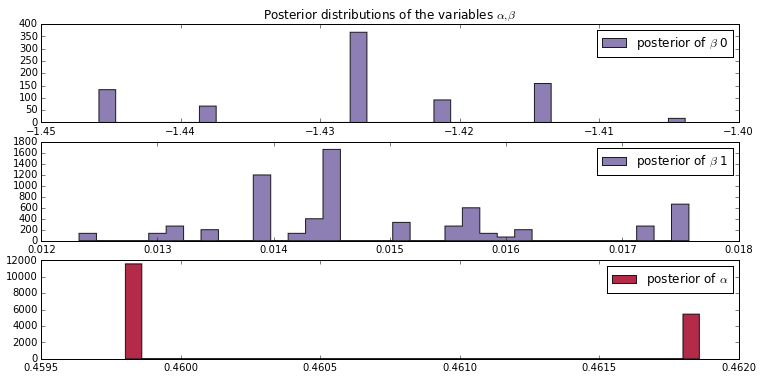

In [21]:
alpha_samples = mcmc.trace('alpha')[:, None]  # best to make them 1d
beta0_samples = mcmc.trace('x_0')[:, None]
beta1_samples = mcmc.trace('x_1')[:, None]


figsize(12.5, 6)

# histogram of the samples:
plt.subplot(311)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta0_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$ 0", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(312)
plt.hist(beta1_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$ 1", color="#7A68A6", normed=True)
plt.legend()


plt.subplot(313)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.legend();